In [1]:
import sys
sys.path.append('../')

import torch
import numpy as np
import pandas as pd
from scipy import sparse
from torch.utils.data import Dataset
from tqdm import tqdm

from MyPlot import *
from utils import PieceWiseConst
from ConstCofFVM import UniformFVM, BlockCofProblem
from BaseTester import BaseTester


In [2]:
class C1TestDs(Dataset):
	def __init__(self, cofs, refs, dtype, device):
		self.cofs = torch.from_numpy(cofs).to(dtype)
		self.refs = torch.from_numpy(refs).to(dtype)
		self.dtype = dtype
		self.device = device
			
	def __len__(self):
		return len(self.cofs)

	def __getitem__(self, index):
		cof = self.cofs[index]

		data = cof.to(self.dtype).to(self.device)

		ref = self.refs[index]
		ref = ref.to(self.dtype).to(self.device)

		return data[None, ...], ref, cof

class C3TestDs(Dataset):
	def __init__(self, cofs, refs, xx, yy, dtype, device):
		self.cofs = torch.from_numpy(cofs).to(dtype)
		self.refs = torch.from_numpy(refs).to(dtype)
		self.xx = torch.from_numpy(xx).to(dtype)
		self.yy = torch.from_numpy(yy).to(dtype)

		self.dtype = dtype
		self.device = device
			
	def __len__(self):
		return len(self.cofs)

	def __getitem__(self, index):
		cof = self.cofs[index]
		data = torch.stack([self.xx, self.yy, cof])
		data = data.to(self.dtype).to(self.device)

		ref = self.refs[index]
		ref = ref.to(self.dtype).to(self.device)

		return data, ref, cof

class CofTester(BaseTester):
	def __init__(self, **kwargs):
		super().__init__(**kwargs)
		self.mesh()
	
	def init_test_ds(self, DataN, GridSize, area=((0, 0), (1, 1)), save_path=None, load_path=None):
		if load_path is None:
			cofs, refs = [], []
			# Randomly sample data
			for t in [2, 3, 4]:
				for _ in range(DataN):
					mu = np.random.uniform(0.1, 10, (t, t))
					pwc = PieceWiseConst(mu, area)
					cofs.append(pwc(self.xx, self.yy))

			solver = UniformFVM(area, GridSize, GridSize, None)
			for idx, cof in tqdm(enumerate(cofs)):
				problem = BlockCofProblem(cof, GridSize, area)
				A = solver.get_A(problem)
				b = solver.get_B(problem)
				u = sparse.linalg.spsolve(A.tocsr(), b).reshape(GridSize, GridSize)
				refs.append(u)

			refs = np.stack(refs)
			cofs = np.stack(cofs)

			if not save_path is None:
				p = Path(f'{save_path}/{GridSize}')
				if not p.is_dir():
					p.mkdir(parents=True)
				np.save(p/'cofs.npy', cofs)
				np.save(p/'refs.npy', refs)

		else:
			refs = np.load(f'{load_path}/{GridSize}/refs.npy')
			cofs = np.load(f'{load_path}/{GridSize}/cofs.npy')
			refs = refs[-DataN:]
			cofs = cofs[-DataN:]
		print(cofs.shape)
		print(self.kwargs['net_kwargs']['in_channels'])
		
		match self.kwargs['net_kwargs']['in_channels']:
			case 1:
				test_ds = C1TestDs(cofs, refs, self.dtype, self.device)
			case 3:
				test_ds = C3TestDs(cofs, refs, self.xx, self.yy, self.dtype, self.device)
		self.ds = test_ds
		# return test_ds
	
	def test(self, exp_name, DataN, best_or_last, save_path, load_path):
		self.load_kwargs(exp_name)
		self.init_test_ds(DataN, self.GridSize, self.area, save_path=save_path, load_path=load_path)
		self.load_ckpt(best_or_last, exp_name)

		df = {
			'l2': []
		}
		with torch.no_grad():
			for i, (data, ref, cof) in enumerate(self.ds):
				data = data[None,...]
				pre = self.net(data)

				l2 = self.l2(pre, ref).item()
				# print(l2)
				# if l2 >= 9e-4:
				# 	continue
				df['l2'].append(l2)

				# self.save_img(f"{self.img_save_path}/{exp_name}/TestCase-{i}", pre, ref, cof)
		p = Path(f"{self.img_save_path}/{exp_name}")
		if not p.is_dir():
			p.mkdir(parents=True)
		df = pd.DataFrame(df)
		df.to_csv(f"{self.img_save_path}/{exp_name}/l2.csv", index=False)
		
	def save_img(self, path, pre, ans, cof):
		p = Path(path)
		if not p.is_dir():
			p.mkdir(parents=True)
		plt.rcParams['font.size'] = 18  # Default font size

		pre = pre.cpu().numpy().reshape(self.GridSize, self.GridSize)
		ans = ans.cpu().numpy().reshape(self.GridSize, self.GridSize)
		cof = cof.cpu().numpy().reshape(self.GridSize, self.GridSize)

		save_surf(path, pre, self.xx, self.yy, 'surf_pre')
		save_surf(path, ans, self.xx, self.yy, 'surf_ref')
		save_ctf(path, pre, ans, self.xx, self.yy)
		save_contour(path, pre, ans, self.xx, self.yy, levels=None)
		save_img_force(path, cof, 'cof', vmin=0.1, vmax=10)

In [16]:
cof_tester = CofTester(
    GridSize=96,
    area=((0, 0), (1, 1)),
    ckpt_save_path=f'model_save',
    hyper_parameters_save_path = f'./hyper_parameters', 
    img_save_path = f'./images', 
    device='cuda',
    dtype=torch.float,
    # mus = np.random.uniform(0.1, 10, (10, 2, 2)),
	)

exp_name = 'JJQC3-96-ResBottleNeck-4#4#6#6#8-4#4#6#6#8-2-layer-max-reflect-jac-15-10000-5'
# exp_name = 'VaryUNetC3relu'
DataN = 6000
best_or_last = 'last'
cof_tester.test(exp_name, DataN, best_or_last, save_path=None, load_path='./TestData')
# cof_tester.init_test_ds()

(6000, 96, 96)
3


/home/whu-jjq/workspace/fvm/fit_multicof/../BaseTester.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(f"{self.ckpt_save_path}/{exp_name}/{best_or_las

(6000, 1)
0.006208430018222569


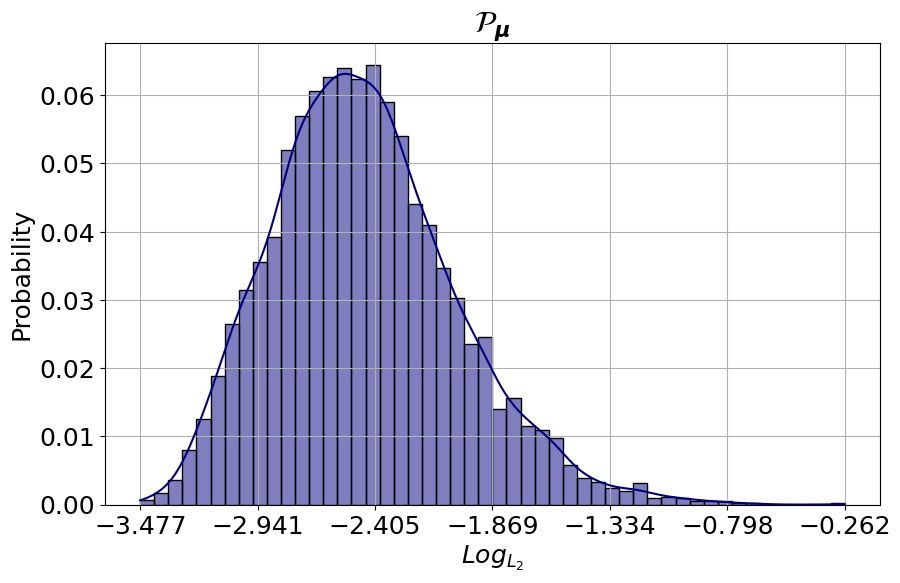

0.006208430018222569


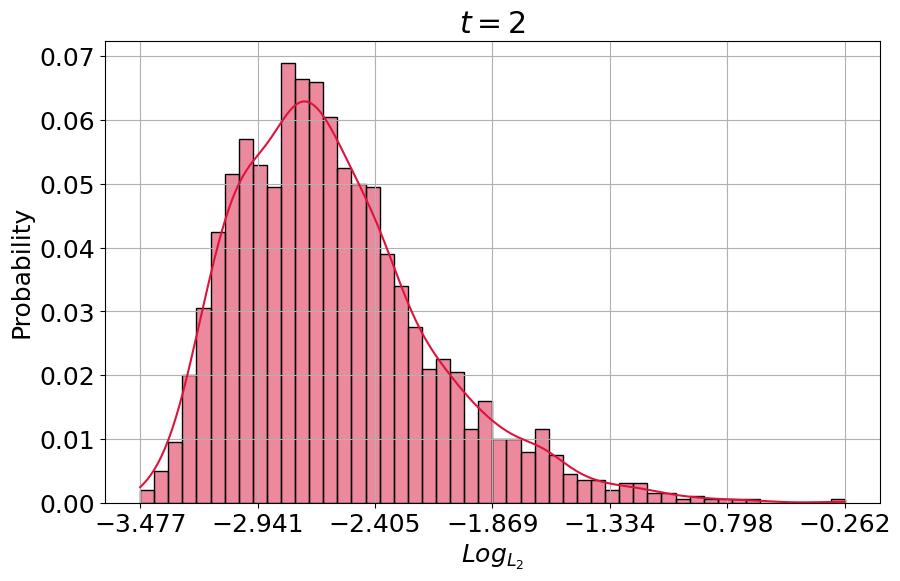

0.006208430018222569


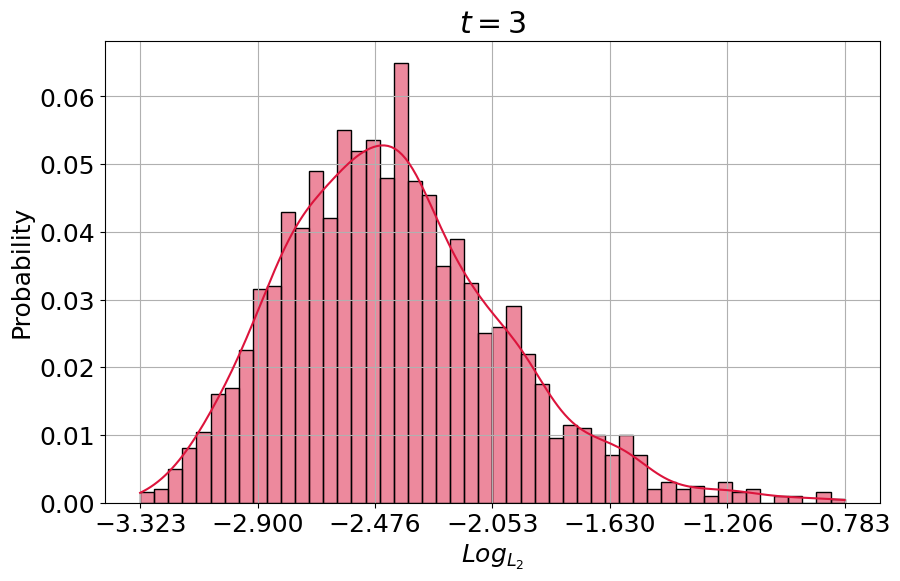

0.006208430018222569


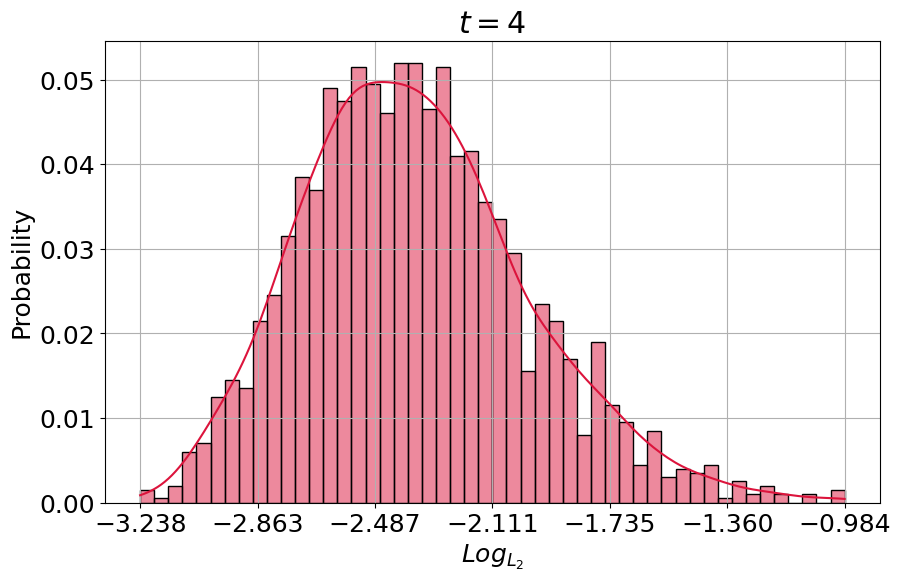

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# df = pd.read_csv('./JJQC3-96-ResBottleNeck-4#4#6#6#8-4#4#6#6#8-2-layer-max-reflect-jac-15-10000-5.csv')
df = pd.read_csv('l2.csv')
print(df.shape)
fig = plt.figure(figsize=(10, 6))  # Set the figure size
plt.rcParams['font.size'] = 18  # Default font size
data = np.log10(df['l2'].values)
sns.histplot(
data,
bins=50,  # Number of bins
kde=True,  # Add KDE (Kernel Density Estimate)
stat='probability',  # Normalize the histogram
color='navy',  # Color of the bars
edgecolor='black'  # Color of the edges
)
print(df['l2'].mean())

# Customization
plt.title(r'$\mathcal{P}_\boldsymbol{\mu}$')  # Title of the plot
plt.xlabel('$Log_{L_2}$')  # X-axis label
plt.xticks(np.linspace(data.min(), data.max(), 7))
plt.ylabel('Probability')  # Y-axis label
plt.grid(True)  # Show grid lines
plt.show()
fig.savefig(f'test_all.png')
plt.close()

DataN = 2000
for i in range(3):
	fig = plt.figure(figsize=(10, 6))  # Set the figure size
	plt.rcParams['font.size'] = 18  # Default font size
	data = np.log10(df['l2'].values[i*DataN: (i+1)*DataN])
	sns.histplot(
	data,
	bins=50,  # Number of bins
	kde=True,  # Add KDE (Kernel Density Estimate)
	stat='probability',  # Normalize the histogram
	color='crimson',  # Color of the bars
	edgecolor='black'  # Color of the edges
	)
	print(df['l2'].mean())

	# Customization
	plt.title(f'$t={i+2}$')  # Title of the plot
	plt.xlabel('$Log_{L_2}$')  # X-axis label
	plt.xticks(np.linspace(data.min(), data.max(), 7))
	plt.ylabel('Probability')  # Y-axis label
	plt.grid(True)  # Show grid lines
	plt.show()
	fig.savefig(f'test_t={i+2}')
	plt.close()